<h1 align="center">Appendix A</h1>
<h2 align="center">SVM Analysis on HARTH Dataset</h2> 
<h3 align="center">Name: Andy Malinsky</h3> 
<h4 align="center">Date: 8/12/2024</h4> 

In [20]:
# Import libraries
import requests
import zipfile
import io
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


np.random.seed(24) # set random seed for reproducibility

## Data Preparation

In [2]:
# Load Data from url into dataframes
zip_file_url = "https://archive.ics.uci.edu/static/public/779/harth.zip"
files = ['S006.csv', 'S008.csv', 'S009.csv', 'S010.csv', 'S012.csv', 'S013.csv',
         'S014.csv', 'S015.csv', 'S016.csv', 'S017.csv', 'S018.csv', 'S019.csv',
         'S020.csv', 'S021.csv', 'S022.csv', 'S023.csv', 'S024.csv', 'S025.csv',
         'S026.csv', 'S027.csv', 'S028.csv', 'S029.csv']
loaded_data = {}

# Function to load individual CSV files into pandas DataFrame
def load_csv(file_name, zip_file):
    with zip_file.open('harth/' + file_name) as csv_file:
        df = pd.read_csv(csv_file)
        loaded_data[file_name] = df
        return df
response = requests.get(zip_file_url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    dataframes = [load_csv(file_name, zip_file) for file_name in files]

df = pd.concat(dataframes, ignore_index=True)
df = df[['timestamp','back_x','back_y','back_z','thigh_x','thigh_y','thigh_z','label']]
df.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6
1,2019-01-12 00:00:00.010,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6
2,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6
3,2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6
4,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6


In [46]:
# Map Activity Labels
activity_label = {
    1: '1: Walking',
    2: '2: Running',
    3: '3: Shuffling',
    4: '4: Stairs (Ascending)',
    5: '5: Stairs (Descending)',
    6: '6: Standing',
    7: '7: Sitting',
    8: '8: Lying',
    13: '9: Cycling (Sit)',
    14: '10: Cycling (Stand)',
    130: '11: Cycling (Sit, Inactive)',
    140: '12: Cycling (Stand, Inactive)'
}
df_map = df.copy()
df_map['label'] = df['label'].replace(activity_label)
df_map.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6: Standing
1,2019-01-12 00:00:00.010,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6: Standing
2,2019-01-12 00:00:00.020,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6: Standing
3,2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6: Standing
4,2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6: Standing


In [29]:
# Function to split into scaled independent and dependent
def split_and_scale_data(df, cal_test=False):
    # Split Features Into Independent and Dependent
    x = df[['back_x','back_y','back_z','thigh_x','thigh_y','thigh_z']]
    y = df[['label']].values.ravel()
    
    # Normalize Data
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = pd.DataFrame(min_max_scaler.fit_transform(x), columns=list(x.columns.tolist()), index=x.index)

    if not cal_test:
        print('Mean:\n', x_scaled.mean())
        print('\nStandard deviation:\n', x_scaled.std())
    x_scaled.head()
    
    return x_scaled, y

x_scaled, y = split_and_scale_data(df_map)
x_scaled.head()

Mean:
 back_x     0.691337
back_y     0.397642
back_z     0.557743
thigh_x    0.462827
thigh_y    0.501229
thigh_z    0.510472
dtype: float64

Standard deviation:
 back_x     0.036689
back_y     0.021406
back_z     0.031761
thigh_x    0.039147
thigh_y    0.024283
thigh_z    0.044867
dtype: float64


,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z
0,0.703455,0.426609,0.613294,0.181707,0.481255,0.530862
1,0.725814,0.424971,0.600355,0.556293,0.517861,0.508362
2,0.663551,0.416125,0.557949,0.497792,0.495021,0.456216
3,0.714286,0.400405,0.567765,0.402866,0.440477,0.474140
4,0.742824,0.394070,0.562615,0.465790,0.508732,0.447770


## Exploratory Data Analysis

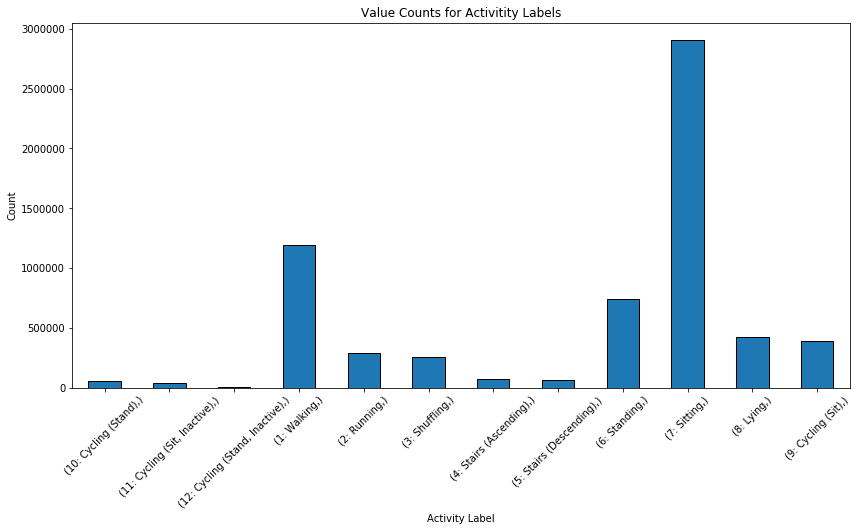

In [30]:
# Histogram of activity label value counts
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
df_map[['label']].value_counts().sort_index().plot(kind='bar', ax=ax, edgecolor='black')
ax.set_xlabel('Activity Label')
ax.set_ylabel('Count')
ax.set_title('Value Counts for Activitity Labels')
fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

## SVM Model Training and Analysis

In [33]:
# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=24)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (5169062, 6)
x_test shape: (1292266, 6)
y_train shape: (5169062,)
y_test shape: (1292266,)


In [34]:
# Fit a baseline classifier with default parameters
clf = SGDClassifier(random_state=24, n_jobs=-1)
clf.fit(x_train, y_train) 
y_pred = clf.predict(x_test)
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 2)) # Evaluate model performance
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.61
                               precision    recall  f1-score   support

          10: Cycling (Stand)       0.00      0.00      0.00     11171
  11: Cycling (Sit, Inactive)       0.00      0.00      0.00      8314
12: Cycling (Stand, Inactive)       0.00      0.00      0.00      1583
                   1: Walking       0.37      0.57      0.45    239884
                   2: Running       0.02      0.00      0.00     57811
                 3: Shuffling       0.01      0.00      0.00     50976
        4: Stairs (Ascending)       0.00      0.00      0.00     15231
       5: Stairs (Descending)       0.00      0.00      0.00     13446
                  6: Standing       0.19      0.06      0.09    148400
                   7: Sitting       0.76      0.98      0.86    580847
                     8: Lying       0.61      0.83      0.70     85958
             9: Cycling (Sit)       0.40      0.00      0.00     78645

                     accuracy                           0.61

In [35]:
# K-Fold Cross Validation on Baseline Model Parameters
scores = cross_val_score(clf, x_scaled, y, cv=5)
print('5-Fold Validation Scores:', scores)
print('5-Fold Validation Min Score:', round(np.min(scores), 2))
print('5-Fold Validation Max Score:', round(np.max(scores), 2))
print('5-Fold Validation Average Score:', round(np.mean(scores), 2))

5-Fold Validation Scores: [0.61395255 0.59078626 0.52647984 0.60825992 0.60046662]
5-Fold Validation Min Score: 0.53
5-Fold Validation Max Score: 0.61
5-Fold Validation Average Score: 0.59


## Hyperparameter Tuning

In [25]:
# Hyperparameter grid search
param_grid = {
    'alpha': [1e-1, 1e-4, 1e-7], # regularization multiplier
    'loss': ['hinge', 'log'],
    'early_stopping': [False, True],
    'n_jobs': [-1],
    'random_state': [24]
}
grid = GridSearchCV(SGDClassifier(), param_grid, refit = True, verbose = 3, cv=3, n_jobs=6) # with 3 fold cross validation
grid.fit(x_train, y_train) # fitting the model for grid search 

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done  36 out of  36 | elapsed: 13.1min finished


GridSearchCV(cv=3, estimator=SGDClassifier(), n_jobs=6,
             param_grid={'alpha': [0.1, 0.0001, 1e-07],
                         'early_stopping': [False, True],
                         'loss': ['hinge', 'log'], 'n_jobs': [-1],
                         'random_state': [24]},
             verbose=3)

In [31]:
print(grid.best_params_) # print best parameter after tuning 
print(grid.best_estimator_) # print how our model looks after hyper-parameter tuning 
grid_results = pd.DataFrame(grid.cv_results_)
grid_results

{'alpha': 1e-07, 'early_stopping': False, 'loss': 'log', 'n_jobs': -1, 'random_state': 24}
SGDClassifier(alpha=1e-07, loss='log', n_jobs=-1, random_state=24)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_early_stopping,param_loss,param_n_jobs,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,48.633227,0.368087,6.173822,0.381346,0.1,False,hinge,-1,24,"{'alpha': 0.1, 'early_stopping': False, 'loss'...",0.467441,0.492773,0.496944,0.485719,1.303623e-02,10
1,54.059716,0.182716,3.043858,0.128489,0.1,False,log,-1,24,"{'alpha': 0.1, 'early_stopping': False, 'loss'...",0.449183,0.449183,0.449183,0.449183,1.228929e-07,11
2,192.105850,7.551914,8.995277,4.046982,0.1,True,hinge,-1,24,"{'alpha': 0.1, 'early_stopping': True, 'loss':...",0.475997,0.487418,0.496420,0.486611,8.356943e-03,9
3,196.003759,2.916719,6.386919,0.284197,0.1,True,log,-1,24,"{'alpha': 0.1, 'early_stopping': True, 'loss':...",0.449183,0.449183,0.449183,0.449183,1.228929e-07,11
4,35.945204,6.041239,15.881860,2.519241,0.0001,False,hinge,-1,24,"{'alpha': 0.0001, 'early_stopping': False, 'lo...",0.634891,0.619452,0.518681,0.591008,5.152960e-02,6
5,49.777212,0.733766,4.513930,1.300293,0.0001,False,log,-1,24,"{'alpha': 0.0001, 'early_stopping': False, 'lo...",0.617619,0.618794,0.619696,0.618703,8.505835e-04,4
6,193.726564,1.309879,7.285848,4.187460,0.0001,True,hinge,-1,24,"{'alpha': 0.0001, 'early_stopping': True, 'los...",0.549602,0.645079,0.623196,0.605959,4.083933e-02,5
7,190.407440,1.814896,4.148904,0.296106,0.0001,True,log,-1,24,"{'alpha': 0.0001, 'early_stopping': True, 'los...",0.617938,0.621790,0.623304,0.621011,2.258687e-03,3
8,149.229578,5.072565,8.783854,4.382851,0.0,False,hinge,-1,24,"{'alpha': 1e-07, 'early_stopping': False, 'los...",0.538435,0.661253,0.554284,0.584657,5.454650e-02,7
9,135.411207,2.860327,3.100032,0.306293,0.0,False,log,-1,24,"{'alpha': 1e-07, 'early_stopping': False, 'los...",0.661932,0.667481,0.660473,0.663295,3.018855e-03,1


In [32]:
# Fit an adjusted classifier with default parameters
clf_adjusted = SGDClassifier(alpha=1e-7, loss='log', n_jobs=-1, random_state=24)
clf_adjusted.fit(x_train, y_train) 
y_pred = clf_adjusted.predict(x_test)
print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred), 2)) # Evaluate model performance
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.66
                               precision    recall  f1-score   support

          10: Cycling (Stand)       0.00      0.00      0.00     11171
  11: Cycling (Sit, Inactive)       0.00      0.00      0.00      8314
12: Cycling (Stand, Inactive)       0.00      0.00      0.00      1583
                   1: Walking       0.38      0.87      0.53    239884
                   2: Running       0.55      0.03      0.06     57811
                 3: Shuffling       0.00      0.00      0.00     50976
        4: Stairs (Ascending)       0.00      0.00      0.00     15231
       5: Stairs (Descending)       0.00      0.00      0.00     13446
                  6: Standing       0.00      0.00      0.00    148400
                   7: Sitting       0.88      0.98      0.93    580847
                     8: Lying       0.83      0.91      0.87     85958
             9: Cycling (Sit)       0.00      0.00      0.00     78645

                     accuracy                           0.66

In [28]:
# K-Fold Cross Validation on Adjusted Model Parameters
scores = cross_val_score(clf_adjusted, x_scaled, y, cv=5)
print('5-Fold Validation Scores:', scores)
print('5-Fold Validation Min Score:', round(np.min(scores), 2))
print('5-Fold Validation Max Score:', round(np.max(scores), 2))
print('5-Fold Validation Average Score:', round(np.mean(scores), 2))

5-Fold Validation Scores: [0.67937793 0.62922959 0.67532458 0.66289422 0.5674966 ]
5-Fold Validation Min Score: 0.57
5-Fold Validation Max Score: 0.68
5-Fold Validation Average Score: 0.64


## Metabolic Calorie Counter Experiment

In [38]:
from METcalories import calories

In [37]:
activity_label_inv = {v: k for k, v in activity_label.items()} # inverse label map

# Function to test prediction per person
def predict_calories_burned(dataPath):
    print('\nRunning Test for:', dataPath)
    data = loaded_data[dataPath]
    d_x, d_y = split_and_scale_data(data, True)
    d_pred = list(map(activity_label_inv.get, clf.predict(d_x)))
    cosine_sim = round(cosine_similarity([d_pred], [d_y])[0][0], 2)
    label_variance = round(np.var(d_y), 2)
    print('Cosine similarity Predicted vs Actual:', cosine_sim) # cosine similarity of predicted vs actual labels
    
    # Calculate calories burned on actual vs predicted
    timestamp = data['timestamp'] # extract the timestamp data
    weight = 70 # Assume 70kg weight for application

    sum_act_cal = 0
    start_time = timestamp[0]
    end_time = timestamp[0]
    activity = d_y[0]
    # Calculate MET calories on actual labels
    for i in range(len(timestamp)):
        # if activity label changes then find the calories for activity
        if (activity != d_y[i]):
            # Add to MET Total Calories
            sum_act_cal = sum_act_cal + calories(start_time, end_time, weight, activity)
            # Reset for next activity in sensor data
            activity = d_y[i]
            start_time = timestamp[i]
            end_time = timestamp[i]
        else:
            # Set end time to next value
            end_time = timestamp[i]
        
    # Calculate MET calories on predicted labels
    sum_pred_cal = 0
    start_time = timestamp[0]
    end_time = timestamp[0]
    activity = d_pred[0]
    for i in range(len(timestamp)):
        # if activity label changes then find the calories for activity
        if (activity != d_pred[i]):
            # Add to MET Total Calories
            sum_pred_cal = sum_pred_cal + calories(start_time, end_time, weight, activity)
            # Reset for next activity in sensor data
            activity = d_pred[i]
            start_time = timestamp[i]
            end_time = timestamp[i]
        else:
            # Set end time to next value
            end_time = timestamp[i]
        
    print('Total Actual MET Calories Burned: %5.2f' % sum_act_cal)
    print('Total Predicted MET Calories Burned: %5.2f' % sum_pred_cal)
    total_error = abs(round(sum_pred_cal - sum_act_cal, 2))
    print('Total Absolute Error (Predicted - Actual):', total_error)
    print('Variance in labels:', label_variance)
    
    return cosine_sim, label_variance, total_error

In [39]:
# Run Calorie Test on All Data Samples
cosine_similarities = []
label_variances = []
total_errors = []

for dataset in loaded_data:
    cosine_sim, label_variance, total_error =  predict_calories_burned(dataset)
    cosine_similarities.append(cosine_sim)
    label_variances.append(label_variance)
    total_errors.append(total_error)


Running Test for: S006.csv
Cosine similarity Predicted vs Actual: 0.45
Total Actual MET Calories Burned: 162.69
Total Predicted MET Calories Burned: 76.48
Total Absolute Error (Predicted - Actual): 86.21
Variance in labels: 413.24

Running Test for: S008.csv
Cosine similarity Predicted vs Actual: 0.72
Total Actual MET Calories Burned: 278.09
Total Predicted MET Calories Burned: 118.27
Total Absolute Error (Predicted - Actual): 159.82
Variance in labels: 41.55

Running Test for: S009.csv
Cosine similarity Predicted vs Actual: 0.55
Total Actual MET Calories Burned: 467.61
Total Predicted MET Calories Burned: 62.95
Total Absolute Error (Predicted - Actual): 404.66
Variance in labels: 887.37

Running Test for: S010.csv
Cosine similarity Predicted vs Actual: 0.79
Total Actual MET Calories Burned: 369.37
Total Predicted MET Calories Burned: 144.53
Total Absolute Error (Predicted - Actual): 224.84
Variance in labels: 6.37

Running Test for: S012.csv
Cosine similarity Predicted vs Actual: 0.9

## Scatter Plots of Cosine Similarity vs Label Variance vs Total Absolute Error

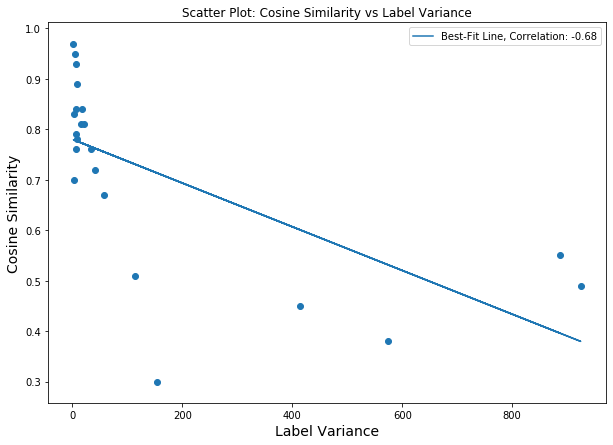

In [40]:
x_plot = np.asarray(label_variances, dtype=np.float32)
y_plot = np.asarray(cosine_similarities, dtype=np.float32)

fig = plt.figure(figsize=(10, 7))
plt.scatter(x_plot, y_plot)
plt.xlabel("Label Variance", size=14)
plt.ylabel("Cosine Similarity", size=14)
plt.title('Scatter Plot: Cosine Similarity vs Label Variance')
a, b = np.polyfit(x_plot, y_plot, 1) # find line of best fit
plt.plot(x_plot, a*(x_plot)+b) # add line of best fit to plot

# calculate correlation using the covariance and standard deviations
correlation = round((np.cov(x_plot,y_plot) / (x_plot.std() * y_plot.std()))[0,1], 2)
plt.legend(['Best-Fit Line, Correlation: '+str(correlation)], loc='upper right')
plt.show()

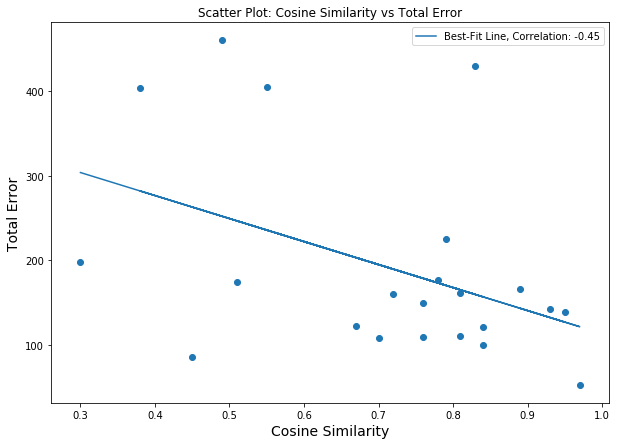

In [41]:
x_plot = np.asarray(cosine_similarities, dtype=np.float32)
y_plot = np.asarray(total_errors, dtype=np.float32)

fig = plt.figure(figsize=(10, 7))
plt.scatter(x_plot, y_plot)
plt.xlabel("Cosine Similarity", size=14)
plt.ylabel("Total Error", size=14)
plt.title('Scatter Plot: Cosine Similarity vs Total Error')
a, b = np.polyfit(x_plot, y_plot, 1) # find line of best fit
plt.plot(x_plot, a*(x_plot)+b) # add line of best fit to plot

# calculate correlation using the covariance and standard deviations
correlation = round((np.cov(x_plot,y_plot) / (x_plot.std() * y_plot.std()))[0,1], 2)
plt.legend(['Best-Fit Line, Correlation: '+str(correlation)], loc='upper right')
plt.show()

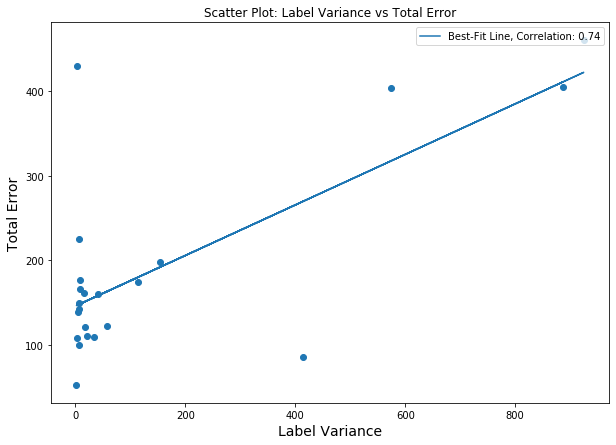

In [42]:
x_plot = np.asarray(label_variances, dtype=np.float32)
y_plot = np.asarray(total_errors, dtype=np.float32)

fig = plt.figure(figsize=(10, 7))
plt.scatter(x_plot, y_plot)
plt.xlabel("Label Variance", size=14)
plt.ylabel("Total Error", size=14)
plt.title('Scatter Plot: Label Variance vs Total Error')
a, b = np.polyfit(x_plot, y_plot, 1) # find line of best fit
plt.plot(x_plot, a*(x_plot)+b) # add line of best fit to plot

# calculate correlation using the covariance and standard deviations
correlation = round((np.cov(x_plot,y_plot) / (x_plot.std() * y_plot.std()))[0,1], 2)
plt.legend(['Best-Fit Line, Correlation: '+str(correlation)], loc='upper right')
plt.show()

In [60]:
# Value Counts for S012.csv
loaded_data['S012.csv']['label'].value_counts()

7    311722
6     22360
8     18892
1     12958
3      7192
4      4320
5      2772
2      2198
Name: label, dtype: int64

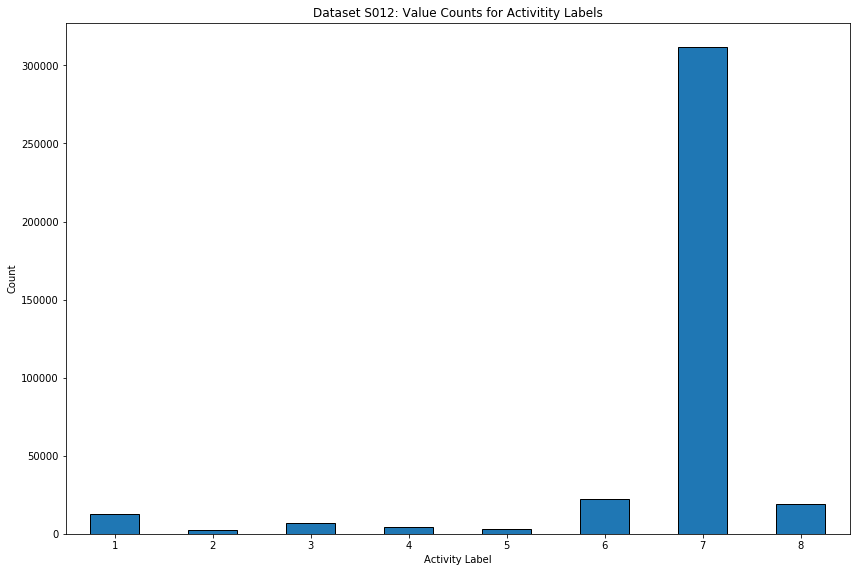

In [62]:
# Histogram of S012 activity value counts
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
loaded_data['S012.csv']['label'].value_counts().sort_index().plot(kind='bar', ax=ax, edgecolor='black')
ax.set_xlabel('Activity Label')
ax.set_ylabel('Count')
ax.set_title('Dataset S012: Value Counts for Activitity Labels')
fig.tight_layout()
plt.xticks(rotation=0)
plt.show()

In [54]:
# Value Counts for S029.csv
loaded_data['S029.csv']['label'].value_counts()

1      121460
2       17774
6       12177
13      10443
3        5702
8        4842
7        3406
130      1590
5         936
4         386
Name: label, dtype: int64

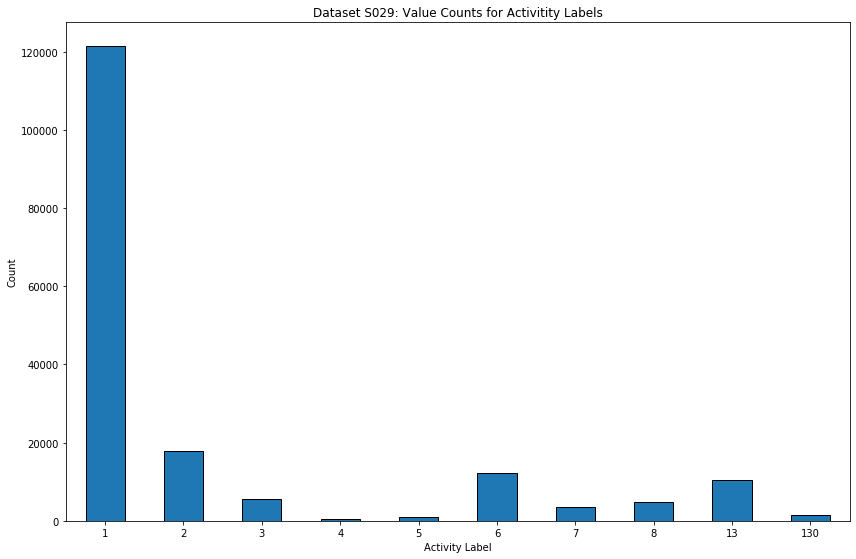

In [61]:
# Histogram of S012 activity value counts
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
loaded_data['S029.csv']['label'].value_counts().sort_index().plot(kind='bar', ax=ax, edgecolor='black')
ax.set_xlabel('Activity Label')
ax.set_ylabel('Count')
ax.set_title('Dataset S029: Value Counts for Activitity Labels')
fig.tight_layout()
plt.xticks(rotation=0)
plt.show()